In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bz2
import re
import zipfile
import os
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_file_path = '/content/drive/MyDrive/deep_fake.zip'
destination_directory = '/content/deep_fake'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_directory)

# Print confirmation message
print("Unzipping complete!")

import random
dataset_dir = '/content/deep_fake/Dataset/Train/Real'
folder = dataset_dir

random_img_path = os.path.join(folder, random.choice(os.listdir(folder)))
print("Random image size before preprocessing:", Image.open(random_img_path).size)

Unzipping complete!
Random image size before preprocessing: (256, 256)


In [ ]:
from torchvision import datasets, transforms
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
dataset = datasets.ImageFolder(root="/content/deep_fake/Dataset/Train", transform=data_transform)


In [ ]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels to numeric values (0 or 1)
encoded_labels = label_encoder.fit_transform(dataset.classes)

# Print the encoded labels
print(encoded_labels)

print("Original class labels:")
for i, label in enumerate(label_encoder.classes_):
    print(f"Encoded label {encoded_labels[i]} corresponds to class '{label}'")

[0 1]
Original class labels:
Encoded label 0 corresponds to class 'Fake'
Encoded label 1 corresponds to class 'Real'


In [ ]:
from torch.utils.data import Subset

# Separate samples by class
real_samples = [idx for idx, (image, label) in enumerate(dataset.samples) if dataset.classes[label] == "Real"]
fake_samples = [idx for idx, (image, label) in enumerate(dataset.samples) if dataset.classes[label] == "Fake"]

# Randomly sample 20,000 samples from each class
real_samples = np.random.choice(real_samples, 25000, replace=False)
fake_samples = np.random.choice(fake_samples, 25000, replace=False)

# Combine the sampled indices
filtered_indices = np.concatenate([real_samples, fake_samples])
filtered_samples = [dataset.samples[idx] for idx in filtered_indices]

# Create a Subset dataset using the filtered samples
filtered_dataset = Subset(dataset, filtered_indices)

dataset = filtered_dataset
# Define sizes for train, validation, and test sets
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into train, validation, and test sets
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])
vali_size = int(0.11112*len(train_set))
train_size = len(train_set) - vali_size
train_set, vali_set = torch.utils.data.random_split(train_set, [train_size, vali_size])

# Create DataLoader for train, validation, and test sets
train_loader = DataLoader(train_set, batch_size=32,shuffle=True)
vali_loader = DataLoader(vali_set, batch_size=32,shuffle=True)
test_loader = DataLoader(test_set, batch_size=32,shuffle=True)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import alexnet, resnet18, densenet121
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

class Ensemble(nn.Module):
    def __init__(self, num_classes):
        super(Ensemble, self).__init__()

        # Load pre-trained models
        self.alexnet = alexnet(pretrained=True)
        self.vit = timm.create_model("vit_base_patch16_224", pretrained=True)
        self.densenet = densenet121(pretrained=True)
        self.resnet = resnet18(pretrained=True)

        # Modify the classifiers to match the number of output classes
        self.alexnet.classifier[6] = nn.Linear(4096, num_classes)
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)
        self.densenet.classifier = nn.Linear(1024, num_classes)
        self.resnet.fc = nn.Linear(512, num_classes)

        # Enable gradient calculation for the last layer
        self.alexnet.classifier[6].requires_grad_(True)
        self.vit.head.requires_grad_(True)
        self.densenet.classifier.requires_grad_(True)
        self.resnet.fc.requires_grad_(True)

    def forward(self, x):
        # Forward pass through each model
        alexnet_out = self.alexnet(x.clone())  # Clone input to avoid in-place modification
        vit_out = self.vit(x.clone())
        densenet_out = self.densenet(x.clone())
        resnet_out = self.resnet(x)

        # Average the predictions from each model
        avg_out = (alexnet_out + vit_out + resnet_out + densenet_out) / 4

        return avg_out

# Example usage:
num_classes = 2  # Change this to the number of output classes in your dataset
model = Ensemble(num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 195MB/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hu

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 177MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(ms

In [ ]:
from tqdm import tqdm

def train_and_validate(model, train_loader, vali_loader, optimizer, loss_fn, device,l2_shceduler = False, num_epochs=10, early_stopping=None):
    train_loss, train_accuracy, validation_loss, validation_accuracy = [], [], [], []
    best_val_accuracy = 0
    epochs_no_improve = 0
    early_stop = False
    l = 0

    for epoch in range(num_epochs):
        model.train()
        running_train_loss, running_train_correct, total_train = 0.0, 0, 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            if l2_shceduler:
              l2loss = 0.0
              for i in model.parameters():
                l2loss = l2loss + torch.norm(i)
              loss = loss + (l*l2loss)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            running_train_correct += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss.append(running_train_loss / len(train_loader))
        train_accuracy.append(running_train_correct / total_train)

        # Validation
        model.eval()
        running_val_loss, running_val_correct, total_val = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(vali_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                running_val_correct += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss_epoch = running_val_loss / len(vali_loader)
        val_acc_epoch = running_val_correct / total_val
        validation_loss.append(val_loss_epoch)
        validation_accuracy.append(val_acc_epoch)

        # Print stats
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training Loss: {train_loss[-1]:.4f}, Accuracy: {train_accuracy[-1]:.4f}")
        print(f"Validation Loss: {validation_loss[-1]:.4f}, Accuracy: {validation_accuracy[-1]:.4f}")

        # Check if validation accuracy has improved
        if val_acc_epoch > best_val_accuracy:
            best_val_accuracy = val_acc_epoch
            torch.save(model.state_dict(), 'best_model.pth')
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Check for early stopping
        if early_stopping and epochs_no_improve >= early_stopping:
            print(f'Early stopping triggered after {epochs_no_improve} epochs without improvement')
            early_stop = True
            break

    if not early_stop:
        print('Training completed without early stopping.')

    return train_loss, train_accuracy, validation_loss, validation_accuracy

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
# Train and validate the model
train_loss, train_accuracy, val_loss, val_accuracy = train_and_validate(
    model=model,
    train_loader=train_loader,
    vali_loader=vali_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    device=device,
    num_epochs=10
)

Epoch 1/10 - Validation: 100%|██████████| 157/157 [00:31<00:00,  5.04it/s]


Epoch 1/10
Training Loss: 0.1023, Accuracy: 0.9593
Validation Loss: 0.0682, Accuracy: 0.9716


Epoch 2/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.10it/s]


Epoch 2/10
Training Loss: 0.0587, Accuracy: 0.9755
Validation Loss: 0.0709, Accuracy: 0.9718


Epoch 3/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.12it/s]


Epoch 3/10
Training Loss: 0.0501, Accuracy: 0.9801
Validation Loss: 0.0492, Accuracy: 0.9816


Epoch 4/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.12it/s]


Epoch 4/10
Training Loss: 0.0393, Accuracy: 0.9834
Validation Loss: 0.0642, Accuracy: 0.9778


Epoch 5/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.12it/s]


Epoch 5/10
Training Loss: 0.0353, Accuracy: 0.9865
Validation Loss: 0.0619, Accuracy: 0.9788


Epoch 6/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.12it/s]


Epoch 6/10
Training Loss: 0.0284, Accuracy: 0.9888
Validation Loss: 0.0721, Accuracy: 0.9732


Epoch 7/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.14it/s]


Epoch 7/10
Training Loss: 0.0271, Accuracy: 0.9887
Validation Loss: 0.0608, Accuracy: 0.9788


Epoch 8/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.18it/s]


Epoch 8/10
Training Loss: 0.0208, Accuracy: 0.9921
Validation Loss: 0.0725, Accuracy: 0.9792


Epoch 9/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.08it/s]


Epoch 9/10
Training Loss: 0.0214, Accuracy: 0.9915
Validation Loss: 0.0685, Accuracy: 0.9784


Epoch 10/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.17it/s]

Epoch 10/10
Training Loss: 0.0159, Accuracy: 0.9937
Validation Loss: 0.0628, Accuracy: 0.9790
Training completed without early stopping.


In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def test_model(model, test_loader, loss_fn, device):
    model.load_state_dict(torch.load('best_model.pth'))
    model.to(device)
    model.eval()

    all_predictions = []
    all_true_labels = []
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating test data"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            probabilities = F.sigmoid(outputs)
            predictions = torch.argmax(probabilities, dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = (np.array(all_predictions) == np.array(all_true_labels)).mean() * 100

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    return test_loss, test_accuracy, all_true_labels, all_predictions

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import seaborn as sns

def report_and_plot_results(train_accuracy, train_loss, val_accuracy, val_loss, test_accuracy, test_loss, y_true, y_pred):
    # Report results
    print(f"Training Accuracy: {np.mean(train_accuracy):.2f}%")
    print(f"Training Loss: {np.mean(train_loss):.4f}")
    print(f"Validation Accuracy: {np.mean(val_accuracy):.2f}%")
    print(f"Validation Loss: {np.mean(val_loss):.4f}")
    print(f"Testing Accuracy: {test_accuracy:.2f}%")
    print(f"Testing Loss: {test_loss:.4f}")

    # Plot accuracy over time
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss over time
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:
test_loss, test_accuracy, y_true, y_pred = test_model(
    model=model,
    test_loader=test_loader,
    loss_fn=criterion,
    device=device
)

Evaluating test data: 100%|██████████| 157/157 [00:30<00:00,  5.15it/s]

Test Loss: 0.0517
Test Accuracy: 97.78%


Training Accuracy: 0.98%
Training Loss: 0.0399
Validation Accuracy: 0.98%
Validation Loss: 0.0651
Testing Accuracy: 97.78%
Testing Loss: 0.0517


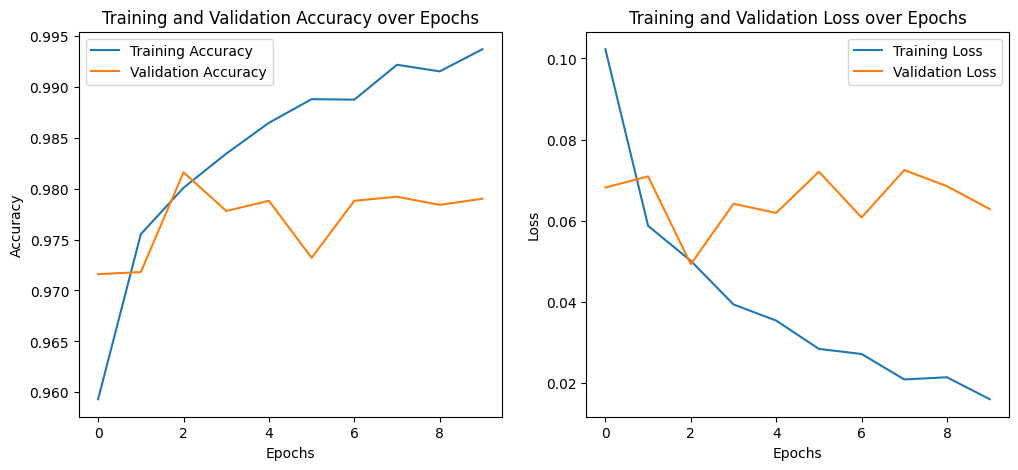

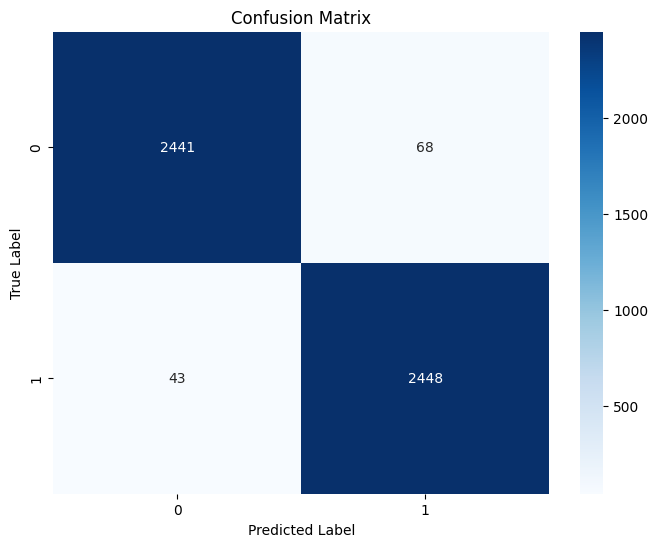

In [ ]:
report_and_plot_results(train_accuracy, train_loss, val_accuracy, val_loss, test_accuracy, test_loss, y_true, y_pred)

In [ ]:
# Train and validate the model
train_loss, train_accuracy, val_loss, val_accuracy = train_and_validate(
    model=model,
    train_loader=train_loader,
    vali_loader=vali_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    device=device,
    num_epochs=10,
    early_stopping=4
)

Epoch 1/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.15it/s]


Epoch 1/10
Training Loss: 0.1041, Accuracy: 0.9582
Validation Loss: 0.0648, Accuracy: 0.9724


Epoch 2/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.09it/s]


Epoch 2/10
Training Loss: 0.0590, Accuracy: 0.9767
Validation Loss: 0.0476, Accuracy: 0.9824


Epoch 3/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.17it/s]


Epoch 3/10
Training Loss: 0.0466, Accuracy: 0.9812
Validation Loss: 0.0640, Accuracy: 0.9736


Epoch 4/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.17it/s]


Epoch 4/10
Training Loss: 0.0383, Accuracy: 0.9848
Validation Loss: 0.0705, Accuracy: 0.9746


Epoch 5/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.12it/s]


Epoch 5/10
Training Loss: 0.0346, Accuracy: 0.9861
Validation Loss: 0.0716, Accuracy: 0.9744


Epoch 6/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.10it/s]

Epoch 6/10
Training Loss: 0.0294, Accuracy: 0.9881
Validation Loss: 0.0523, Accuracy: 0.9794
Early stopping triggered after 4 epochs without improvement


In [ ]:

test_loss, test_accuracy, y_true, y_pred = test_model(
    model=model,
    test_loader=test_loader,
    loss_fn=criterion,
    device=device
)

Evaluating test data: 100%|██████████| 157/157 [00:30<00:00,  5.12it/s]

Test Loss: 0.0490
Test Accuracy: 98.18%


Training Accuracy: 0.98%
Training Loss: 0.0520
Validation Accuracy: 0.98%
Validation Loss: 0.0618
Testing Accuracy: 98.18%
Testing Loss: 0.0490


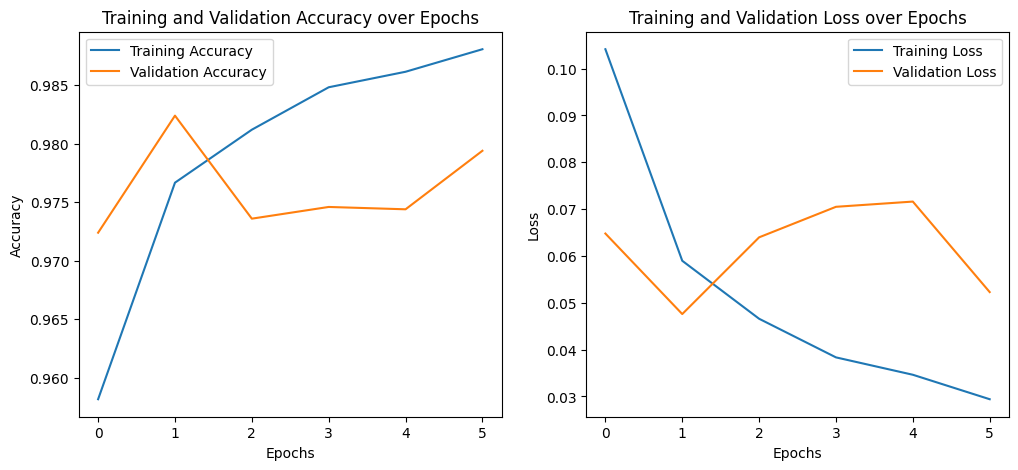

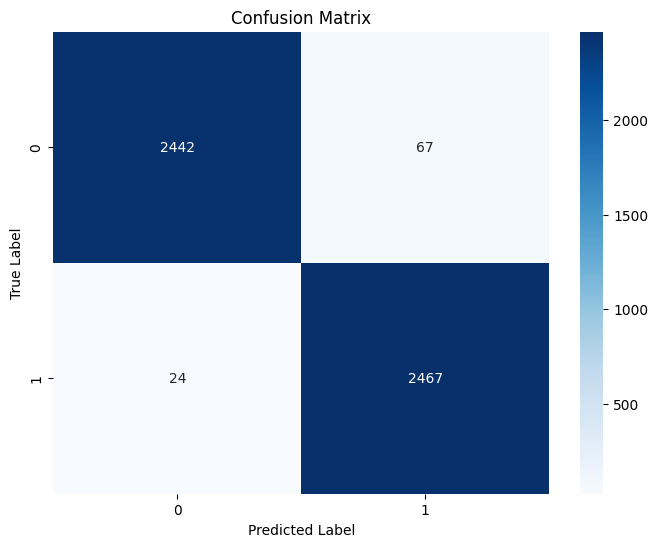

In [ ]:
report_and_plot_results(train_accuracy, train_loss, val_accuracy, val_loss, test_accuracy, test_loss, y_true, y_pred)

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# Train and validate the model
train_loss, train_accuracy, val_loss, val_accuracy = train_and_validate(
    model=model,
    train_loader=train_loader,
    vali_loader=vali_loader,
    optimizer=optimizer,
    loss_fn=criterion,
    device=device,
    num_epochs=10,
    l2_shceduler=True
)

Epoch 1/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.20it/s]


Epoch 1/10
Training Loss: 0.1027, Accuracy: 0.9599
Validation Loss: 0.0759, Accuracy: 0.9690


Epoch 2/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.20it/s]


Epoch 2/10
Training Loss: 0.0578, Accuracy: 0.9771
Validation Loss: 0.0561, Accuracy: 0.9772


Epoch 3/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.22it/s]


Epoch 3/10
Training Loss: 0.0458, Accuracy: 0.9818
Validation Loss: 0.0536, Accuracy: 0.9782


Epoch 4/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.23it/s]


Epoch 4/10
Training Loss: 0.0389, Accuracy: 0.9851
Validation Loss: 0.0607, Accuracy: 0.9742


Epoch 5/10 - Validation: 100%|██████████| 157/157 [00:29<00:00,  5.26it/s]


Epoch 5/10
Training Loss: 0.0320, Accuracy: 0.9874
Validation Loss: 0.0935, Accuracy: 0.9666


Epoch 6/10 - Validation: 100%|██████████| 157/157 [00:29<00:00,  5.24it/s]


Epoch 6/10
Training Loss: 0.0279, Accuracy: 0.9892
Validation Loss: 0.0636, Accuracy: 0.9770


Epoch 7/10 - Validation: 100%|██████████| 157/157 [00:29<00:00,  5.26it/s]


Epoch 7/10
Training Loss: 0.0245, Accuracy: 0.9900
Validation Loss: 0.0780, Accuracy: 0.9708


Epoch 8/10 - Validation: 100%|██████████| 157/157 [00:29<00:00,  5.25it/s]


Epoch 8/10
Training Loss: 0.0229, Accuracy: 0.9913
Validation Loss: 0.0736, Accuracy: 0.9768


Epoch 9/10 - Validation: 100%|██████████| 157/157 [00:29<00:00,  5.25it/s]


Epoch 9/10
Training Loss: 0.0186, Accuracy: 0.9931
Validation Loss: 0.0746, Accuracy: 0.9798


Epoch 10/10 - Validation: 100%|██████████| 157/157 [00:30<00:00,  5.21it/s]

Epoch 10/10
Training Loss: 0.0167, Accuracy: 0.9936
Validation Loss: 0.0803, Accuracy: 0.9784
Training completed without early stopping.


In [ ]:
test_loss, test_accuracy, y_true, y_pred = test_model(
    model=model,
    test_loader=test_loader,
    loss_fn=criterion,
    device=device
)

Evaluating test data: 100%|██████████| 157/157 [00:29<00:00,  5.27it/s]

Test Loss: 0.0676
Test Accuracy: 98.00%


Training Accuracy: 0.98%
Training Loss: 0.0388
Validation Accuracy: 0.97%
Validation Loss: 0.0710
Testing Accuracy: 98.00%
Testing Loss: 0.0676


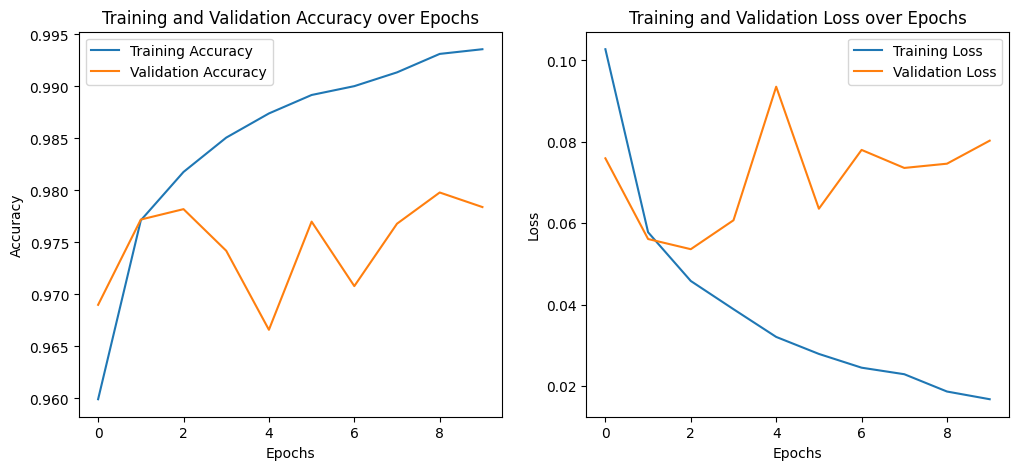

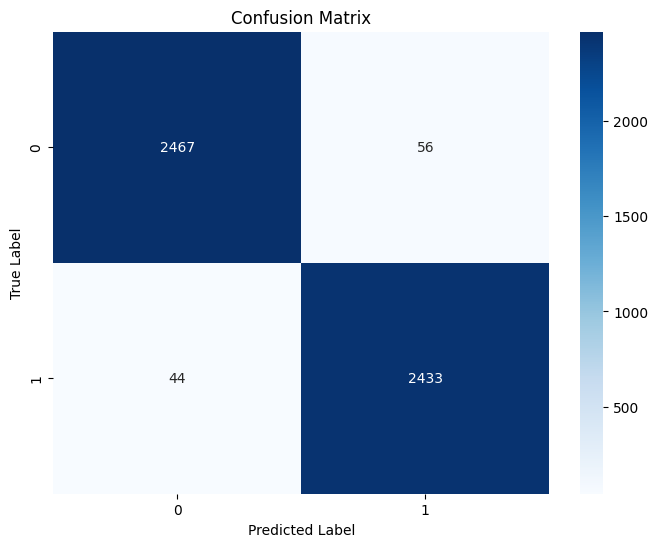

In [ ]:
report_and_plot_results(train_accuracy, train_loss, val_accuracy, val_loss, test_accuracy, test_loss, y_true, y_pred)